In [406]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np

from mne.datasets import eegbci

In [407]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = 'MNE-eegbci-data/files/eegmmidb/1.0.0'
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)         # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        print("Done.")
    
    def filter(self, freq):
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = -1
        tmax = 4 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y

In [408]:
# home directory + datasets folder
path = os.path.join(os.path.expanduser("~"), 'datasets')
base_url = 'https://physionet.org/files/eegmmidb/1.0.0/'
# subjects = [1]
runs = [3, 7]
subjects = [i for i in range(1, 11)]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)



>>> Start download from: https://physionet.org/files/eegmmidb/1.0.0/.
Done.
>>> Extract all subjects from: C:\Users\anujg\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0.
Loading file #1/20: S001R03.edf
Loading file #2/20: S001R07.edf
Loading file #3/20: S002R03.edf
Loading file #4/20: S002R07.edf
Loading file #5/20: S003R03.edf
Loading file #6/20: S003R07.edf
Loading file #7/20: S004R03.edf
Loading file #8/20: S004R07.edf
Loading file #9/20: S005R03.edf
Loading file #10/20: S005R07.edf
Loading file #11/20: S006R03.edf
Loading file #12/20: S006R07.edf
Loading file #13/20: S007R03.edf
Loading file #14/20: S007R07.edf
Loading file #15/20: S008R03.edf
Loading file #16/20: S008R07.edf
Loading file #17/20: S009R03.edf
Loading file #18/20: S009R07.edf
Loading file #19/20: S010R03.edf
Loading file #20/20: S010R07.edf
Done.


In [409]:
# apply filter
freq = (8., 30.)
eeg.filter(freq=freq)

eeg.create_epochs()

>>> Apply filter.
Filtering raw data in 20 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)

>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data for 300 events and 801 original time points ...
0 bad epochs dropped
Done.


In [410]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)

(300, 64, 801) (300,)


In [411]:
eeg.raw

<RawEDF | S001R03.edf, 64 x 395520 (2472.0 s), ~193.2 MB, data loaded>

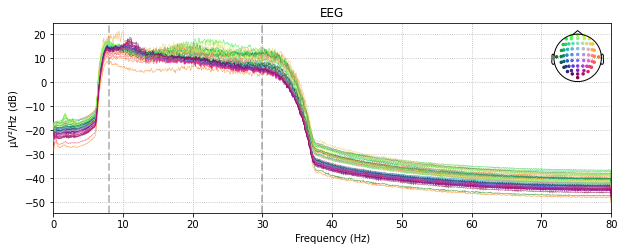

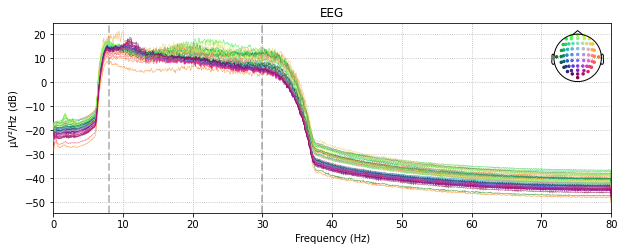

In [412]:
eeg.raw.plot_psd()

In [413]:
# import numpy as np
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.autograd import Variable
# import torch.nn.functional as F
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from torch.nn import MaxPool1d
# class CNN_Model_v1(nn.Module):
#     def __init__(self):
#         super(CNN_Model_v1, self).__init__()
#         # Layer 1
#         self.conv1 = nn.Conv1d(in_channels=1,out_channels=25,kernel_size= (11, 1, 1, 25))
#         self.relu = nn.LeakyReLU()
#         self.conv2 = nn.Conv1d(in_channels=25,out_channels=25,kernel_size= (1, 2, 25, 25))
#         self.batchnorm1 = nn.BatchNorm2d(25)
#         self.maxpool1 = MaxPool1d(kernel_size=(1,3,1,1), stride=(1,3,1,1))
#         self.conv3 = nn.Conv1d(in_channels=25,out_channels=50,kernel_size= (11, 1, 25, 50))
#         self.maxpool2 = MaxPool1d(kernel_size=(1,3,1,1), stride=(1,3,1,1))
#         self.conv4 = nn.Conv1d(in_channels=50,out_channels=100,kernel_size= (11, 1, 50, 100))
#         self.batchnorm2 = nn.BatchNorm2d(100)
#         self.maxpool3 = MaxPool1d(kernel_size=(1,3,1,1), stride=(1,3,1,1))
#         self.conv5 = nn.Conv1d(in_channels=100,out_channels=200,kernel_size= (11, 1, 100, 200))
#         self.batchnorm3 = nn.BatchNorm2d(200)
#         self.maxpool4 = MaxPool1d(kernel_size=(1,2,1,1), stride=(1,2,1,1))
#         self.fc1 = nn.Linear(800, 2)

#     # print shapes after each layer, match with paper's shape
#     # implement dropout
#     # create sequentially later, conv - batchnorm - activa - dropout
#     # compare with LSTM, CSP, CNN1D etc
#     # spectogram, SFT, CNN2D
    
#     def forward(self, x):
#         # Layer 1
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.batchnorm1(x)
#         x = self.relu(x)
#         x = self.maxpool1(x)
#         x = self.conv3(x)
#         x = self.relu(x)
#         x = self.maxpool2(x)
#         x = self.conv4(x)
#         x = self.batchnorm2(x)
#         x = self.relu(x)
#         x = self.maxpool3(x)
#         x = self.conv5(x)
#         x = self.batchnorm3(x)
#         x = self.maxpool4(x)
#         x = nn.sigmoid(self.fc1(x))
#         return x


# # net = CNN_Model_v1()
# #print(net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 120, 64)).cuda(0))))
# # The model
# # net = CNN_Model()

# #if cuda.is_available():
#  #   net = net.cuda()

In [414]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import MaxPool1d
class CNN_Model_v1(nn.Module):
    def __init__(self):
        super(CNN_Model_v1, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=25,kernel_size= (1))
        self.relu = nn.LeakyReLU()
        self.conv2 = nn.Conv1d(in_channels=25,out_channels=25,kernel_size= (1))
        self.batchnorm1 = nn.BatchNorm2d(25)
        self.maxpool1 = MaxPool1d(kernel_size=(1), stride=(1))
        self.conv3 = nn.Conv1d(in_channels=25,out_channels=50,kernel_size= (1))
        self.maxpool2 = MaxPool1d(kernel_size=(1), stride=(1))
        self.conv4 = nn.Conv1d(in_channels=50,out_channels=100,kernel_size= (1))
        self.batchnorm2 = nn.BatchNorm2d(100)
        self.maxpool3 = MaxPool1d(kernel_size=(1), stride=(1))
        self.conv5 = nn.Conv1d(in_channels=100,out_channels=200,kernel_size= (1))
        self.batchnorm3 = nn.BatchNorm2d(200)
        self.maxpool4 = MaxPool1d(kernel_size=(1), stride=(1))
#         self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(801, 1)

    # print shapes after each layer, match with paper's shape
    # implement dropout
    # create sequentially later, conv - batchnorm - activa - dropout
    # compare with LSTM, CSP, CNN1D etc
    # spectogram, SFT, CNN2D
    
    def forward(self, x):
        # Layer 1
#         print("input X 1:", x.shape)
        x = self.conv1(x)
#         print("input X 2:", x.shape)
        x = self.relu(x)
#         print("input X 3:", x.shape)
        x = self.conv2(x)
#         print("input X 4:", x.shape)
#         x = self.batchnorm1(x)
#         print("input X 5:", x.shape)
        x = self.relu(x)
#         print("input X 6:", x.shape)
        x = self.maxpool1(x)
#         print("input X 7:", x.shape)
        x = self.conv3(x)
#         print("input X 8:", x.shape)
        x = self.relu(x)
#         print("input X 9:", x.shape)
        x = self.maxpool2(x)
#         print("input X 10:", x.shape)
        x = self.conv4(x)
#         print("input X 11:", x.shape)
#         x = self.batchnorm2(x)
#         print("input X 12:", x.shape)
        x = self.relu(x)
#         print("input X 13:", x.shape)
        x = self.maxpool3(x)
#         print("input X 14:", x.shape)
        x = self.conv5(x)
#         print("input X 15:", x.shape)
#         x = self.batchnorm3(x)
#         print("input X 16:", x.shape)
        x = self.maxpool4(x)
#         print("input X 17:", x.shape)
        x = self.fc1(x)
#         print("input X 18:", x.shape)
#         x = nn.Sigmoid()

        return x


# net = CNN_Model_v1()
#print(net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 120, 64)).cuda(0))))
# The model
# net = CNN_Model()

#if cuda.is_available():
 #   net = net.cuda()

In [415]:
import torch.cuda as cuda

model = CNN_Model_v1()

if cuda.is_available():
    print("cuda available")
    model = model.cuda()

In [416]:
model 

CNN_Model_v1(
  (conv1): Conv1d(1, 25, kernel_size=(1,), stride=(1,))
  (relu): LeakyReLU(negative_slope=0.01)
  (conv2): Conv1d(25, 25, kernel_size=(1,), stride=(1,))
  (batchnorm1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(25, 50, kernel_size=(1,), stride=(1,))
  (maxpool2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(50, 100, kernel_size=(1,), stride=(1,))
  (batchnorm2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(100, 200, kernel_size=(1,), stride=(1,))
  (batchnorm3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Lin

In [417]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model CNN_Model_v1 has 28,752 trainable parameters


In [418]:
# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [419]:

X2 = X[:, 0:1, :]
y = y.reshape(300,1)
print(X2.shape)
print(y.shape)

(300, 1, 801)
(300, 1)


In [420]:
X_torch = torch.from_numpy(X2).float()
y_torch = torch.from_numpy(y)

In [421]:
# XX_torch = torch.unsqueeze(X_torch, 1)

In [422]:
print(X_torch.shape)
print(X_torch.type)
print(X_torch.dtype)

torch.Size([300, 1, 801])
<built-in method type of Tensor object at 0x0000016EAC51F180>
torch.float32


In [423]:
# XX_torch.shape

In [424]:
y_torch.shape

torch.Size([300, 1])

In [425]:
from torch.utils.data import TensorDataset
ds = TensorDataset(X_torch, y_torch)

#Train test split
train_size = int(X_torch.size()[0] * 0.7)
valid_size = int(X_torch.size()[0] * 0.2)
test_size = int(X_torch.size()[0] * 0.1)

In [426]:
train_set, valid_set, test_set = torch.utils.data.random_split(ds, [train_size, valid_size, test_size])

In [427]:
for i in train_set:
    print(i[0].shape)
    break

print(len(train_set))

torch.Size([1, 801])
210


In [428]:
BATCH_SIZE = 30
#Train set loader
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Test set loader
test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [429]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

7
2
1


In [430]:
for i, (signal, label) in enumerate(train_loader):
    print(signal.shape)
    print(label.shape)

torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])


In [436]:
import torch.cuda as cuda
num_epochs = 100

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    print("EPOCH:", epoch)
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()
    
    for i, (items, classes) in enumerate(train_loader):
#         print("ITERATION:", i)
        items = Variable(items)
        classes = Variable(classes)
    
        optimizer.zero_grad()
#         print(items.dtype)
        classes = classes.long()
        outputs = outputs.long()
#         print(classes.dtype)
        outputs = model(items)
        loss = criterion(outputs, classes)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()
    
    for i, (items, classes) in enumerate(valid_loader):
        classes = classes.long()
        outputs = outputs.long()
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(3)
            classes = classes.cuda(3)
        
        outputs = model(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(valid_loader.dataset) * 100.0)
    
    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
               %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))

EPOCH: 0
Epoch 1/100, Tr Loss: 5.2320, Tr Acc: 0.0000, Val Loss: 5.2259, Val Acc: 0.0000
EPOCH: 1
Epoch 2/100, Tr Loss: 5.2250, Tr Acc: 0.0000, Val Loss: 5.2186, Val Acc: 0.0000
EPOCH: 2
Epoch 3/100, Tr Loss: 5.2174, Tr Acc: 0.0000, Val Loss: 5.2109, Val Acc: 0.0000
EPOCH: 3
Epoch 4/100, Tr Loss: 5.2098, Tr Acc: 0.0000, Val Loss: 5.2027, Val Acc: 0.0000
EPOCH: 4
Epoch 5/100, Tr Loss: 5.2015, Tr Acc: 0.0000, Val Loss: 5.1941, Val Acc: 0.0000
EPOCH: 5
Epoch 6/100, Tr Loss: 5.1927, Tr Acc: 0.0000, Val Loss: 5.1851, Val Acc: 0.0000
EPOCH: 6
Epoch 7/100, Tr Loss: 5.1837, Tr Acc: 0.0000, Val Loss: 5.1756, Val Acc: 0.0000
EPOCH: 7
Epoch 8/100, Tr Loss: 5.1742, Tr Acc: 0.0000, Val Loss: 5.1658, Val Acc: 0.0000
EPOCH: 8
Epoch 9/100, Tr Loss: 5.1642, Tr Acc: 0.0000, Val Loss: 5.1554, Val Acc: 0.0000
EPOCH: 9
Epoch 10/100, Tr Loss: 5.1539, Tr Acc: 0.0000, Val Loss: 5.1446, Val Acc: 0.0000
EPOCH: 10
Epoch 11/100, Tr Loss: 5.1430, Tr Acc: 0.0000, Val Loss: 5.1334, Val Acc: 0.0000
EPOCH: 11
Epoch 12

Epoch 90/100, Tr Loss: 2.4223, Tr Acc: 48.0952, Val Loss: 2.3878, Val Acc: 50.0000
EPOCH: 90
Epoch 91/100, Tr Loss: 2.3683, Tr Acc: 48.0952, Val Loss: 2.3340, Val Acc: 50.0000
EPOCH: 91
Epoch 92/100, Tr Loss: 2.3144, Tr Acc: 48.0952, Val Loss: 2.2805, Val Acc: 50.0000
EPOCH: 92
Epoch 93/100, Tr Loss: 2.2609, Tr Acc: 48.0952, Val Loss: 2.2274, Val Acc: 50.0000
EPOCH: 93
Epoch 94/100, Tr Loss: 2.2079, Tr Acc: 48.0952, Val Loss: 2.1747, Val Acc: 50.0000
EPOCH: 94
Epoch 95/100, Tr Loss: 2.1555, Tr Acc: 48.0952, Val Loss: 2.1225, Val Acc: 50.0000
EPOCH: 95
Epoch 96/100, Tr Loss: 2.1033, Tr Acc: 48.0952, Val Loss: 2.0711, Val Acc: 50.0000
EPOCH: 96
Epoch 97/100, Tr Loss: 2.0521, Tr Acc: 48.0952, Val Loss: 2.0203, Val Acc: 50.0000
EPOCH: 97
Epoch 98/100, Tr Loss: 2.0016, Tr Acc: 48.0952, Val Loss: 1.9704, Val Acc: 50.0000
EPOCH: 98
Epoch 99/100, Tr Loss: 1.9518, Tr Acc: 48.0952, Val Loss: 1.9214, Val Acc: 50.0000
EPOCH: 99
Epoch 100/100, Tr Loss: 1.9031, Tr Acc: 48.0952, Val Loss: 1.8734, Val

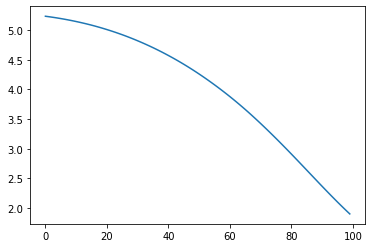

In [437]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.plot(train_loss)


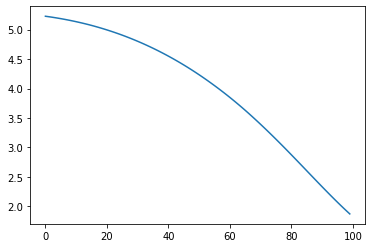

In [438]:
plt.plot(valid_loss)
